분류 성능 평가 지표
+ 정확도 accuracy
+ 오차행렬 confusion matrix
+ 정밀도 precision
+ 재현율 recall
+ F1 스코어
+ ROC AUC

In [22]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
        # fit() 메서드는 아무것도 학습하지 않음.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if (X['Sex'].iloc[i] == 1):
                pred[i]=0
            else:
                pred[i]=1
        return pred

In [23]:
from sklearn.preprocessing import LabelEncoder

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_feature(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df
 
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_feature(df)
    return df

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}' .format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


C:\Users\SM-PC\AppData\Local\Temp\ipykernel_26512\1689397783.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace=True)
C:\Users\SM-PC\AppData\Local\Temp\ipykernel_26512\1689397783.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

데이터 분포도가 균일하지 않은 경우 높은 수치가 나타날 수 있는 것이 정확도 평가 지표의 맹점이다.

오차행렬의 TP, TN, FP, FN 값은 classifier의 성능을 측정할 수 있는 주요 지표인 accuracy, precision, recall 값을 알 수 있다.

+ 재현율이 중요한 경우 : 암 진단, 금융 사기 적발 등 -> 재확인하는 절차를 거치는게 차라리 나은 경우
+ 정밀도가 중요한 경우 : 스팸 메일 여부 판단 등 

정밀도/재현율 trade-off : 한 쪽을 높이면 다른 하나의 수치는 떨어질 가능성이 높음

## 파마 인디언 당뇨병 예측

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


negative 값이 500개, positive 값이 268개로 negative 값이 상대적으로 많다.

In [30]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


null 값은 없고, feature는 모두 숫자형이다.

In [36]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
    F1: {3:.4f}, AUC: {4:.4f}' .format(accuracy, precision, recall, f1, roc_auc))

In [37]:
X = diabetes_data.iloc[:, :-1]  # 마지막 열 제외 모든 열
y = diabetes_data.iloc[:, -1]   # 마지막 열

# stratify=y로 클래스 비율 유지.(데이터 불균형일 때)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926,     F1: 0.6465, AUC: 0.8083


정확도는 77.27%, 재현율은 59.26% 로 측정되었다. 전체 데이터의 65%가 negative이므로 재현율 성능을 올려야 한다.

정밀도 재현율 곡선을 보고 임계값별 정밀도와 재현율 값의 변화를 확인한다.

In [46]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

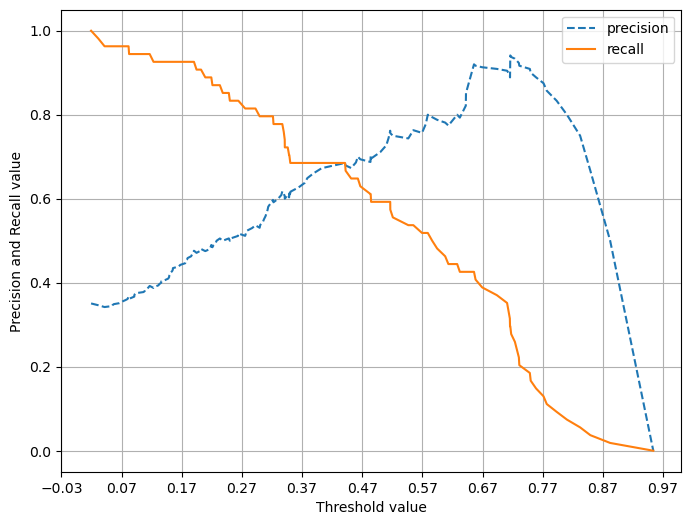

In [47]:
pred_proda_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba)

임계값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 수 있을 것. 하지만 둘 다 0.7이 안되는 수치를 보임.

임계값을 인위적으로 조작하기 전에 다시 데이터 값을 점검하도록 한다.

In [49]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


feature값의 분포도를 살펴 본다.

min 값이 0인 feature가 꽤 많다.(0이면 안되는 값들.. 그냥 0이어서 하는 것이 아니다.) feature의 히스토그램을 확인해본다.

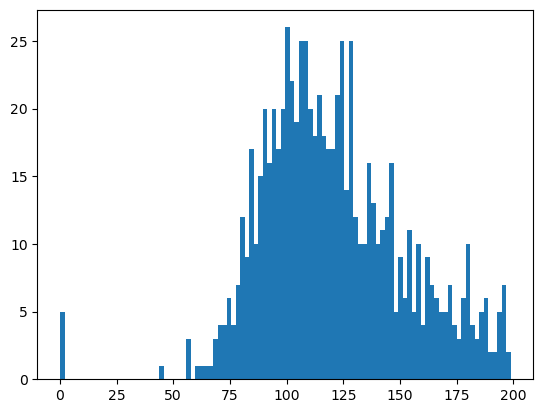

In [50]:
plt.hist(diabetes_data['Glucose'], bins=100)
plt.show()

포도당의 히스토그램을 확인해본 결과 0 값이 일정 수준 존재하는 것을 알 수 있다.

전체 데이터 건수 대비 몇 퍼센트의 비율로 0값이 존재하는지 확인해 본다.

'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'를 확인한다.

In [52]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
total_count = diabetes_data['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2: .2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는  0.65%
BloodPressure 0 건수는 35, 퍼센트는  4.56%
SkinThickness 0 건수는 227, 퍼센트는  29.56%
Insulin 0 건수는 374, 퍼센트는  48.70%
BMI 0 건수는 11, 퍼센트는  1.43%


전체 데이터가 많지 않기 때문에 데이터를 삭제하지 않고 평균값으로 대체한다.

In [53]:
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

0값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환한다.

로지스틱의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋기 때문이다.

In [54]:
X = diabetes_data.iloc[:, :-1]  
y = diabetes_data.iloc[:, -1]  

# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# stratify=y로 클래스 비율 유지.(데이터 불균형일 때)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,     F1: 0.6804, AUC: 0.8433


이제 재현율 수치에 개선이 필요하다.

분류 결정 임계값을 변화시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인해 본다.

In [67]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test,custom_predict, pred_proba_c1)

In [68]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1, 1), thresholds)

임계값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,     F1: 0.6615, AUC: 0.8433
임계값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,     F1: 0.6774, AUC: 0.8433
임계값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,     F1: 0.6667, AUC: 0.8433
임계값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,     F1: 0.6667, AUC: 0.8433
임계값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,     F1: 0.6792, AUC: 0.8433
임계값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,     F1: 0.6857, AUC: 0.8433
임계값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,     F1: 0.6931, AUC: 0.8433
임계값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,     F1: 0.6804, AUC: 0.8433


정확도와 정밀도를 희생하고 재현율을 높이는 데에 가장 좋은 임곗값은 0.33이지만, 정밀도가 0.5972로 매우 저조해졌으니 극단적인 선택이다.

따라서 임계값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 향상시키는 좋은 임계값으로 보인다.

(주관적이라고 생각한다.. 정확한 비교 방법 필요)

In [69]:
# 임계값을 0.48로 설정한 Binarizier 생성
binarizer = Binarizer(threshold=0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))
get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,     F1: 0.6931, AUC: 0.8433
